In [ ]:
import sys
import pandas as pd
from google.oauth2 import service_account  # Add this import
sys.path.append('..')

from src.mimicdf import MIMICDF

# Set up credentials (add this before creating MIMICDF instance)
credentials = service_account.Credentials.from_service_account_file(
    '/home/kasra/Development/config/copper-actor-403003-f084a282499a.json' 
)

# Create instance with credentials
df = MIMICDF(source='gcp', credentials=credentials)


In [ ]:
gmm_data = df.gmm_data()
gmm_data.head()


In [ ]:
print(gmm_data.info())
print(gmm_data.columns)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

def graph_distribution(df, column_name):
    plt.figure(figsize=(10, 6))
    
    # Create histogram
    plt.hist(df[column_name], bins=30, density=True, alpha=0.7)
    
    # Add KDE curve manually
    data = df[column_name].dropna()
    kde_x = np.linspace(data.min(), data.max(), 100)
    kde = gaussian_kde(data)
    plt.plot(kde_x, kde(kde_x), 'r-', lw=2)
    
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

graph_cols = ['age_at_ed', 'hour', 'los_minutes', 'temperature',
              'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity']
for col in graph_cols:
    graph_distribution(gmm_data, col)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def analyze_distribution(df, column_name):
    # Create a figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # 1. Box plot for outlier detection
    ax1.boxplot(df[column_name].dropna())
    ax1.set_title(f'Box Plot of {column_name}')
    
    # 2. Q-Q plot for normal distribution
    stats.probplot(df[column_name].dropna(), dist="norm", plot=ax2)
    ax2.set_title("Normal Q-Q Plot")
    
    # 3. Q-Q plot for logistic distribution
    stats.probplot(df[column_name].dropna(), dist="logistic", plot=ax3)
    ax3.set_title("Logistic Q-Q Plot")
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    data = df[column_name].dropna()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    print(f"\nSummary for {column_name}:")
    print(f"Mean: {data.mean():.2f}")
    print(f"Median: {data.median():.2f}")
    print(f"Std Dev: {data.std():.2f}")
    print(f"Skewness: {data.skew():.2f}")
    print(f"Kurtosis: {data.kurtosis():.2f}")
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {(len(outliers)/len(data))*100:.2f}%")
    
    # Perform normality test
    _, p_value_normal = stats.normaltest(data)
    _, p_value_ks_logistic = stats.kstest(data, 'logistic', args=(data.mean(), data.std()))
    
    print(f"\nNormality test p-value: {p_value_normal:.4f}")
    print(f"Logistic test p-value: {p_value_ks_logistic:.4f}")
    print("-----------------------------------")

# Analyze each column
for col in graph_cols:
    analyze_distribution(gmm_data, col)

In [ ]:
import seaborn as sns
bp_data = gmm_data[['dbp', 'sbp']]
bp_data = bp_data[
    (bp_data['dbp'] > 0) & 
    (bp_data['sbp'] > 0) & 
    (bp_data['dbp'] < 300) & 
    (bp_data['sbp'] < 300)
]
bp_data['flag'] = bp_data['dbp'] < bp_data['sbp']

bp_data.flag.value_counts()




In [ ]:
# Filter blood pressure data and remove physiologically impossible values
bp_data = gmm_data[['dbp', 'sbp']]
bp_data = bp_data[
    (bp_data['dbp'] > 0) & 
    (bp_data['sbp'] > 0) & 
    (bp_data['dbp'] < 300) & 
    (bp_data['sbp'] < 300)
]

# Create an enhanced scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='dbp', y='sbp', data=bp_data, alpha=0.5)

# Customize the plot
plt.title('Systolic vs Diastolic Blood Pressure Distribution')
plt.xlabel('Diastolic Blood Pressure (mmHg)')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add diagonal line where SBP = DBP
plt.plot([0, 300], [0, 300], 'r--', alpha=0.5, label='SBP = DBP')

plt.tight_layout()
plt.show()

In [ ]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

# Filter blood pressure data as before
bp_data = gmm_data[['dbp', 'sbp']]
bp_data = bp_data[
    (bp_data['dbp'] > 0) & 
    (bp_data['sbp'] > 0) & 
    (bp_data['dbp'] < 300) & 
    (bp_data['sbp'] < 300)
]

# Calculate the difference between SBP and DBP
bp_data['bp_diff'] = bp_data['sbp'] - bp_data['dbp']

# 1. Z-score analysis for BP difference
bp_data['bp_diff_zscore'] = stats.zscore(bp_data['bp_diff'])

# 2. Modified Mahalanobis distance calculation
def mahalanobis_distance(x, y):
    data = np.column_stack([x, y])
    mean = np.mean(data, axis=0)
    covariance_matrix = np.cov(data.T)
    inv_covariance_matrix = np.linalg.inv(covariance_matrix)
    
    distances = []
    for point in data:
        diff = point - mean
        dist = np.sqrt(diff.dot(inv_covariance_matrix).dot(diff))
        distances.append(dist)
    
    return np.array(distances)

# Calculate Mahalanobis distances
bp_data['mahalanobis_dist'] = mahalanobis_distance(bp_data['dbp'], bp_data['sbp'])

# 3. Statistical Analysis
print("Statistical Analysis of Blood Pressure Readings:\n")

# Basic statistics
print("1. Basic Statistics:")
print(f"Mean BP Difference (SBP-DBP): {bp_data['bp_diff'].mean():.2f}")
print(f"Median BP Difference: {bp_data['bp_diff'].median():.2f}")
print(f"Std Dev of BP Difference: {bp_data['bp_diff'].std():.2f}\n")

# Identify suspicious readings using different criteria
print("2. Suspicious Readings Detection:")

# a. Basic physiological rule
suspicious_basic = bp_data['dbp'] >= bp_data['sbp']
print(f"Readings where DBP ≥ SBP: {suspicious_basic.sum()} ({suspicious_basic.mean()*100:.2f}%)")

# b. Z-score based
zscore_threshold = 3
suspicious_zscore = np.abs(bp_data['bp_diff_zscore']) > zscore_threshold
print(f"Readings with abnormal BP difference (|z-score| > {zscore_threshold}): {suspicious_zscore.sum()} ({suspicious_zscore.mean()*100:.2f}%)")

# c. Mahalanobis distance based
md_threshold = stats.chi2.ppf(0.975, df=2)  # 97.5th percentile with 2 degrees of freedom
suspicious_md = bp_data['mahalanobis_dist'] > md_threshold
print(f"Readings with abnormal multivariate distribution: {suspicious_md.sum()} ({suspicious_md.mean()*100:.2f}%)")

# 4. Visualization of results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: BP Difference Distribution
ax1.hist(bp_data['bp_diff'], bins=50, density=True, alpha=0.7)
ax1.set_title('Distribution of BP Differences\n(SBP-DBP)')
ax1.set_xlabel('BP Difference (mmHg)')
ax1.set_ylabel('Density')

# Plot 2: Z-score Distribution
ax2.hist(bp_data['bp_diff_zscore'], bins=50, density=True, alpha=0.7)
ax2.axvline(x=-zscore_threshold, color='r', linestyle='--', alpha=0.5)
ax2.axvline(x=zscore_threshold, color='r', linestyle='--', alpha=0.5)
ax2.set_title('Z-score Distribution of\nBP Differences')
ax2.set_xlabel('Z-score')
ax2.set_ylabel('Density')

# Plot 3: Mahalanobis Distance Distribution
ax3.hist(bp_data['mahalanobis_dist'], bins=50, density=True, alpha=0.7)
ax3.axvline(x=md_threshold, color='r', linestyle='--', alpha=0.5)
ax3.set_title('Mahalanobis Distance\nDistribution')
ax3.set_xlabel('Mahalanobis Distance')
ax3.set_ylabel('Density')

plt.tight_layout()
plt.show()

# 5. Cross-validation of methods
print("\n3. Cross-validation of Detection Methods:")
methods_agreement = suspicious_basic & suspicious_zscore & suspicious_md
print(f"Readings flagged by all three methods: {methods_agreement.sum()} ({methods_agreement.mean()*100:.2f}%)")

# Show example of suspicious readings
print("\n4. Sample of Suspicious Readings:")
suspicious_readings = bp_data[methods_agreement].head()
print(suspicious_readings[['dbp', 'sbp', 'bp_diff', 'bp_diff_zscore', 'mahalanobis_dist']])

In [ ]:
o2_data= gmm_data[['o2sat']]
o2_data_valid = o2_data[o2_data['o2sat'] <= 100]   
# plot the distribution of o2sat
plt.hist(o2_data_valid, bins=30, density=True, alpha=0.7)
plt.show()




In [ ]:
resprate_data = gmm_data[['resprate']]
resprate_data_invalid = resprate_data[(resprate_data['resprate'] - resprate_data['resprate'].mean()) / resprate_data['resprate'].std() > 3]
resprate_data_valid = resprate_data[resprate_data['resprate'] > 0]
resprate_data_invalid.describe()

In [ ]:
# ... existing code ...
temp_data = gmm_data[['temperature']]
temp_data_invalid = temp_data[(temp_data['temperature'] - temp_data['temperature'].mean()) / temp_data['temperature'].std() > 3]
temp_data_valid = temp_data[(temp_data['temperature'] > 0) & (temp_data['temperature'] < 120)]

# Print descriptive statistics
print(temp_data_invalid.describe())

# Plot histogram using matplotlib instead of seaborn
plt.figure(figsize=(10, 6))
plt.hist(temp_data_invalid['temperature'], bins=30, density=True, alpha=0.7)
plt.title('Distribution of Valid Temperature Readings')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.show()

In [1]:
import sys
import pandas as pd
from google.oauth2 import service_account  # Add this import
sys.path.append('..')

from src.mimicdf import MIMICDF
from src.DatePreprocessor import DataPreprocessor

# Set up credentials (add this before creating MIMICDF instance)
credentials = service_account.Credentials.from_service_account_file(
    '/home/kasra/Development/config/copper-actor-403003-f084a282499a.json' 
)

# Create instance with credentials
mimicdf = MIMICDF(source='gcp', credentials=credentials)

preprocessor = DataPreprocessor(mimicdf)

# 2. Demonstrate each cleaning step with visualizations
# (Your existing EDA code with explanations)

# 3. Show final preprocessed data
clean_data = preprocessor.prepare_data()
clean_data.head()


Successfully connected to MIMIC-IV ED dataset
Loading edstays...
Table loaded: edstays
Loading age data...
Table loaded: age
Loading time features...
Table loaded: edstays
Loading triage data...
Table loaded: triage
Processing age calculations...
Calculating ED visit age...
Merging time features...
Merging triage features...
Cleaning up columns...

 Dataframe shape: (2588775, 18) 

Dataframe info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2588775 entries, 0 to 2588774
Data columns (total 18 columns):
 #   Column             Dtype  
---  ------             -----  
 0   subject_id         Int64  
 1   stay_id            Int64  
 2   gender             object 
 3   race               object 
 4   arrival_transport  object 
 5   disposition        object 
 6   age_at_ed          Int64  
 7   dow                object 
 8   hour               int32  
 9   los_minutes        float64
 10  temperature        Float64
 11  heartrate          Float64
 12  resprate           Float64
 13 

,subject_id,stay_id,gender,race,arrival_transport,disposition,age_at_ed,dow,hour,los_minutes,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity
0,10000178,31721172,F,ASIAN,WALK IN,HOME,<NA>,Friday,9,332.0,98.5,82.0,16.0,100.0,167.0,86.0,8,3
1,10004371,38482952,F,ASIAN,WALK IN,HOME,<NA>,Tuesday,14,126.0,99.2,88.0,18.0,100.0,154.0,91.0,3,3
2,10005303,32459569,M,ASIAN,WALK IN,HOME,<NA>,Tuesday,12,237.0,98.0,96.0,18.0,100.0,142.0,99.0,7,4
3,10005329,32044805,F,ASIAN,WALK IN,HOME,32,Monday,19,799.0,98.0,82.0,18.0,100.0,122.0,82.0,0,3
4,10009866,37316180,M,ASIAN,WALK IN,HOME,<NA>,Thursday,16,147.0,98.1,77.0,16.0,99.0,121.0,79.0,7,3


In [3]:
clean_data.describe().T

,count,mean,std,min,25%,50%,75%,max
subject_id,2588775.0,15018457.85657,2787061.859239,10000032.0,12591205.0,15229574.0,17338425.0,19999987.0
stay_id,2588775.0,34992963.319132,2891247.663007,30000012.0,32480611.0,35000450.0,37498498.5,39999965.0
age_at_ed,2480153.0,58.802715,16.729216,18.0,48.0,59.0,70.0,103.0
hour,2588775.0,13.449231,5.985713,0.0,10.0,14.0,18.0,23.0
los_minutes,2588688.0,511.885655,444.506008,1.0,262.0,398.0,607.0,29584.166667
temperature,2466790.0,98.052861,1.037024,56.0,97.5,98.0,98.5,111.4
heartrate,2511534.0,86.646825,17.523991,1.0,74.0,86.0,98.0,256.0
resprate,2486454.0,17.758738,2.80055,1.0,16.0,18.0,18.0,209.0
o2sat,2484765.0,97.998919,2.591082,0.0,97.0,98.0,100.0,100.0
sbp,2499369.0,134.983865,23.749686,1.0,119.0,133.0,149.0,299.0


/home/kasra/anaconda3/envs/mimiced/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='los_minutes', ylabel='Count'>

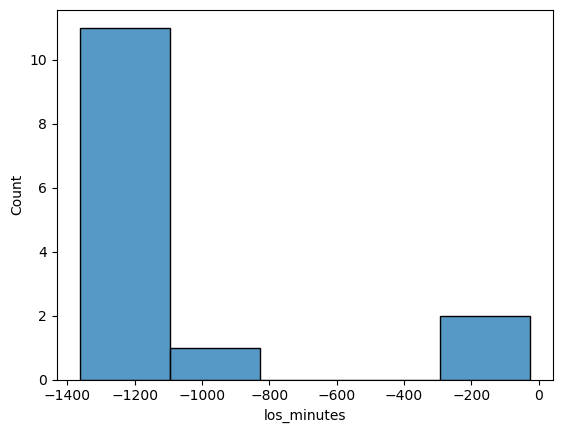

In [9]:
import seaborn as sns
los_data = clean_data.los_minutes
los_data_below_0 = los_data[los_data < 0]
sns.histplot(los_data_below_0)



